In [1]:
import datetime
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from scipy.interpolate import RBFInterpolator

In [2]:
conn = psycopg2.connect(database='migas')

In [3]:
qry = 'SELECT * FROM "migas"."nipreps/fmriprep";'

In [4]:
DF = pd.read_sql_query(qry, conn)
DF.reset_index(drop=True, inplace=True)

/var/folders/r0/2f5n101d1cz85n45dzn0qbkh0000gn/T/ipykernel_49778/903448787.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  DF = pd.read_sql_query(qry, conn)


In [5]:
# Remove time from timestamps
DF["date_minus_time"] = DF["timestamp"].apply(
    lambda _df: datetime.datetime(year=_df.year, month=_df.month, day=_df.day)
)
CUTOFF = datetime.datetime(year=2024, month=1, day=1)
if CUTOFF:
    print(f'Ignoring data before {CUTOFF}')
    DF = DF[DF['date_minus_time'] > CUTOFF]

Ignoring data before 2024-01-01 00:00:00


In [6]:
started_df = DF[DF['status'] == 'R']
grouped_started = started_df.groupby([
    started_df['date_minus_time'].dt.isocalendar().year,
    started_df['date_minus_time'].dt.isocalendar().week,
])['user_id'].count()

In [7]:
success_df = DF[DF['status'] == 'C']
grouped_success = success_df.groupby([
    success_df['date_minus_time'].dt.isocalendar().year,
    success_df['date_minus_time'].dt.isocalendar().week,
])['user_id'].count()

In [8]:
## This is interesting...
session_id_counts = started_df.session_id.value_counts()
session_id_counts

session_id
99f9bb81-2076-4f93-943c-88a1fc24f25e    61
45c3b657-8300-4a7f-bba1-e694c73e8e5a    11
bf1a0bb3-7130-49c2-8ab2-3d5d83faff3b     3
610ede5b-dcf9-4989-8411-ee84f9120ade     3
e00a0c12-ea3a-464d-9540-0e15cea26257     3
                                        ..
c8980c43-9dc9-43a9-be47-963b9e1a95a9     1
804d9d44-25e4-4e04-b045-70c0acb86a99     1
8671d4be-839b-44e1-b341-338a8e0fe194     1
04d972ef-7ea3-43ff-acfa-ca633a80c22d     1
d4b9235c-22c3-4d5f-8e7e-89bd29314428     1
Name: count, Length: 831878, dtype: int64

In [9]:
s_count = success_df.session_id.value_counts()
print(f'Total success: {s_count.sum()}, with {s_count[s_count > 1].sum()} same sessions (?)')

Total success: 678133, with 159 same sessions (?)


In [10]:
indexes = grouped_started.index[1:-1]

year_index = indexes.droplevel("week")
years = sorted(year_index.unique())
weeks_per_year = [(year_index == yr).sum() for yr in years]

In [11]:
# Extract some summary stats
success_data = grouped_success[1:-1]
started_data = grouped_started[1:-1]

abs_success_mean = success_data.values.mean()

success_ratio = 100 * success_data / started_data
success_mean = success_ratio.values.mean()

max_success = (np.argmax(success_ratio), success_ratio.values.max())
max_date = indexes[max_success[0]]
min_success = (np.argmin(success_ratio), success_ratio.values.min())
min_date = indexes[min_success[0]]

<Figure size 640x480 with 0 Axes>

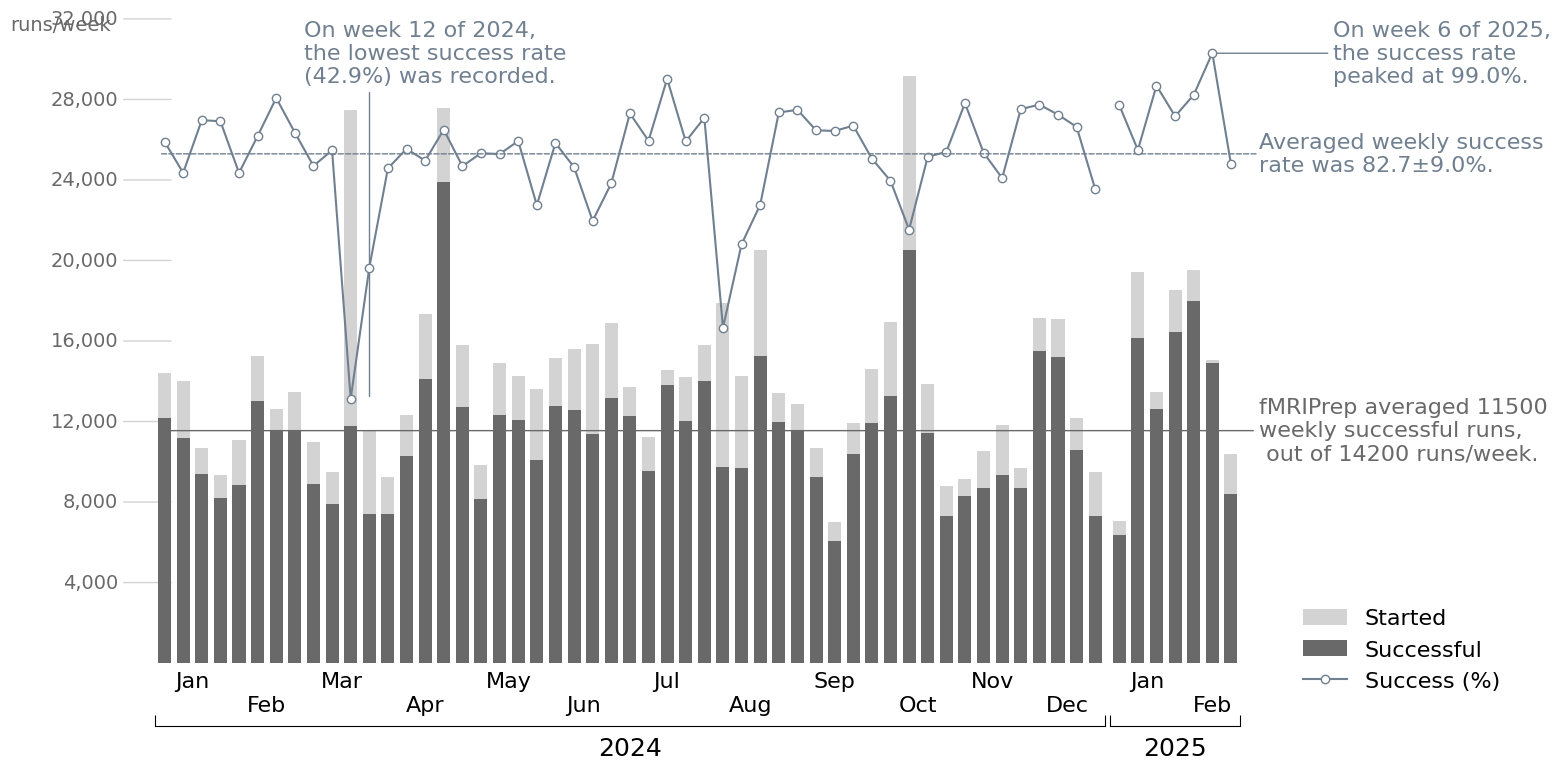

In [12]:
plt.clf()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(years),
    sharey=True,
    gridspec_kw={
        "width_ratios": weeks_per_year,
        "wspace": 0.01,
        "hspace": 0.0,
    },
    figsize=(14,8),
)

xlength = [(year_index == yr).sum() for yr in years]
yticks = [4000, 8000, 12000, 16000]
year_start_index = 0


# Configure y-axis arts-
axes[0].set_yticks(yticks, labels=yticks)
axes[0].yaxis.set_tick_params(length=25, labelsize=16)
axes[0].spines['left'].set_position(('outward', 30))
axes[0].spines['left'].set_color("dimgray")
axes[0].set_ylabel("runs/week", color="dimgrey", fontsize=14, rotation="horizontal");
axes[0].yaxis.set_label_coords(-0.1, 1.02)
axes[0].yaxis.set_label_position("left")


axes_twins = []
for ax_i, yr in enumerate(years):
    x = np.arange(len(started_data[year_index == yr]), dtype=float) + 0.5
    
    bar1 = axes[ax_i].bar(
        x,
        started_data[year_index == yr].values,
        width=0.7,
        label='Started',
        color="lightgrey",
    )
    bar2 = axes[ax_i].bar(
        x,
        success_data[year_index == yr].values,
        width=0.7,
        label='Successful',
        color="dimgrey",
    )

    axes[ax_i].spines['right'].set_visible(False)
    axes[ax_i].spines['top'].set_visible(False)
    axes[ax_i].spines['left'].set_visible(False)
    axes[ax_i].spines['bottom'].set_position(('outward', 45))
    
    axes[ax_i].set_xlim((0.0, xlength[ax_i]))
    axes[ax_i].set_xticks((0.0, xlength[ax_i]))
    axes[ax_i].set_xticklabels([])
    axes[ax_i].tick_params(direction="in", length=8)
    axes[ax_i].set_xlabel(f"{yr}", fontsize=18)

    axes[ax_i].yaxis.set_tick_params(length=0)

    if ax_i > 0:
        axes[ax_i].set_yticks([])
        
    axes_twins.append(axes[ax_i].twinx())
    ax2 = axes_twins[-1]
    lineplot = ax2.plot(
        x,
        success_ratio[year_index == yr].values,
        'o-',
        label="Success (%)",
        color="slategray",
        mfc="white",
        zorder=4,
    )
    ax2.set_ylim(0, 100)
    ax2.set_yticks([])

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    # Label months
    months = [
        datetime.datetime.strptime(f'{yr}-W{week}-1', "%Y-W%W-%w").month
        for _, week in indexes[year_index == yr]
    ]
    for mnum in sorted(set(months)):
        month_x = 0.5 * (xlength[ax_i] - months[::-1].index(mnum) + months.index(mnum))
        axes[ax_i].text(
            month_x,
            -1200 - 1200 * ((mnum + 1) % 2),
            f"{calendar.month_abbr[mnum]}",
            fontsize=16,
            ha="center",
#             transform="data",
        )
        
    axes[ax_i].set_zorder(10)
    ax2.set_zorder(11)

# Add y-axis labels
for i in np.arange(4, 33, step=4, dtype=int):
    axes[0].annotate(
        f"{i},000",
        xy=(1, i * 1000),
        xytext=(-2, i * 1000),
        xycoords="data",
        annotation_clip=False,
        color="dimgrey",
        size=14,
        horizontalalignment="right",
        verticalalignment="center",
        arrowprops={"arrowstyle": "-", "color": "lightgrey"},
    ).set_zorder(0)


# Add annotations
axes[-1].annotate(
    "fMRIPrep averaged"
    f" {int(round(abs_success_mean, -2))}"
    "\nweekly successful runs,\n"
    f" out of {int(round(grouped_started.values[1:-1].mean(), -2))} runs/week.",
    xy=(0 - sum(xlength[:-1]), abs_success_mean),
    xytext=(xlength[-1] + 1, abs_success_mean),
    xycoords="data",
    annotation_clip=False,
    color="dimgrey",
    size=16,
    horizontalalignment="left",
    verticalalignment="center",
    arrowprops={"arrowstyle": "-", "color": "dimgrey"},
    zorder=0,
).set_zorder(0)

axes_twins[-1].annotate(
    "Averaged weekly success\n"
    f"rate was {round(success_mean, 1)}±{round(success_ratio.values.std(), 0)}%.",
    xy=(0 - sum(xlength[:-1]), success_mean),
    xytext=(xlength[-1] + 1, success_mean),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    horizontalalignment="left",
    verticalalignment="center",
    arrowprops={"arrowstyle": "-", "color": "slategray",  "linestyle" : "--", "shrinkA": 0, "shrinkB": 0},
).set_zorder(0)

y_idx = years.index(max_date[0])
axes_twins[y_idx].annotate(
    f"On week {max_date[1]} of {max_date[0]},"
    "\nthe success rate\npeaked at "
    f"{round(max_success[1], 1)}%.",
    xy=(max_date[1] - 0.5, round(max_success[1], 1)),
    # xytext=(sum(xlength[y_idx:]) + 1, round(max_success[1], 1)),
    xytext=(12, round(max_success[1], 1)),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    arrowprops={"arrowstyle": "-", "color": "slategray"},
    horizontalalignment="left",
    verticalalignment="center"
)

y_idx = years.index(min_date[0])
axes_twins[y_idx].annotate(
    f"On week {min_date[1]} of {min_date[0]},"
    "\nthe lowest success rate \n"
    f"({round(min_success[1], 1)}%) was recorded.",
    xy=(min_date[1] - 0.5, round(min_success[1], 1)),
    # xytext=(sum(xlength[y_idx:]) + 1, 26),
    xytext=(xlength[-1] + 1, round(max_success[1], 1)),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    arrowprops={"arrowstyle": "-", "color": "slategray", "connectionstyle": "angle,angleA=0,angleB=90"},
    horizontalalignment="left",
    verticalalignment="center"
)

patches = [bar1, bar2, lineplot[0]]
fig.legend(
    patches,
    [p.get_label() for p in patches],
    loc='lower right',
    bbox_to_anchor=(1.1, 0.05),
    frameon=False,
    mode=None,
    prop={"size": 16}
);

plt.savefig(
    f"{datetime.date.today().strftime('%Y%m%d')}_weekly.png",
    dpi=300,
    bbox_inches='tight',
    facecolor="w",
    edgecolor="w",
);

# Versions

In [13]:
# Group versions into major/minor bins
versions_bin = set()
for version in DF.version.unique():
    if '+' in version or 'rc' in version or 'a' in version:
        continue

    versions_bin.add(version[:-2])

versions_bin = sorted(versions_bin)

In [14]:
excludes = r'\+|rc|a|dev'
versions_success = {}
versions_started = {}

for version in versions_bin:

    ver_suc = success_df[success_df['version'].str[:4] == version]
    ver_suc = ver_suc[~ver_suc['version'].str.contains(excludes)]
    
    ver_sta = started_df[started_df.version == version]
    ver_sta = ver_sta[~ver_sta['version'].str.contains(excludes)]
    
    versions_success[version] = ver_suc.groupby([
        ver_suc['date_minus_time'].dt.isocalendar().year,
        ver_suc['date_minus_time'].dt.isocalendar().week,
    ])['user_id'].count()
    versions_started[version] = ver_sta.groupby([
        ver_sta['date_minus_time'].dt.isocalendar().year,
        ver_sta['date_minus_time'].dt.isocalendar().week,
    ])['user_id'].count()

versions_success = pd.DataFrame(versions_success)
versions_started = pd.DataFrame(versions_started)
versions_success_norm = versions_success.div(versions_success.sum(axis=1), axis=0)
versions_success.sum(0).astype(int)

22.1     21549
23.0     35567
23.1    211420
23.2    207660
24.0     85265
24.1     94957
dtype: int64

In [15]:
# Ignore columns of versions below 5000 executions all time
versions_success = versions_success.loc[:, versions_success.sum(0) > 5000]

data = versions_success[1:-1].fillna(0.0)
xs = np.arange(len(data))
xnew = np.linspace(0.0, len(data), num=14 * len(data))
xnew_inc = xnew[1] - xnew[0]

smoothed_data = RBFInterpolator(xs[:, np.newaxis], data.values)(xnew[:, np.newaxis])

In [16]:
versions_success.columns

Index(['22.1', '23.0', '23.1', '23.2', '24.0', '24.1'], dtype='object')

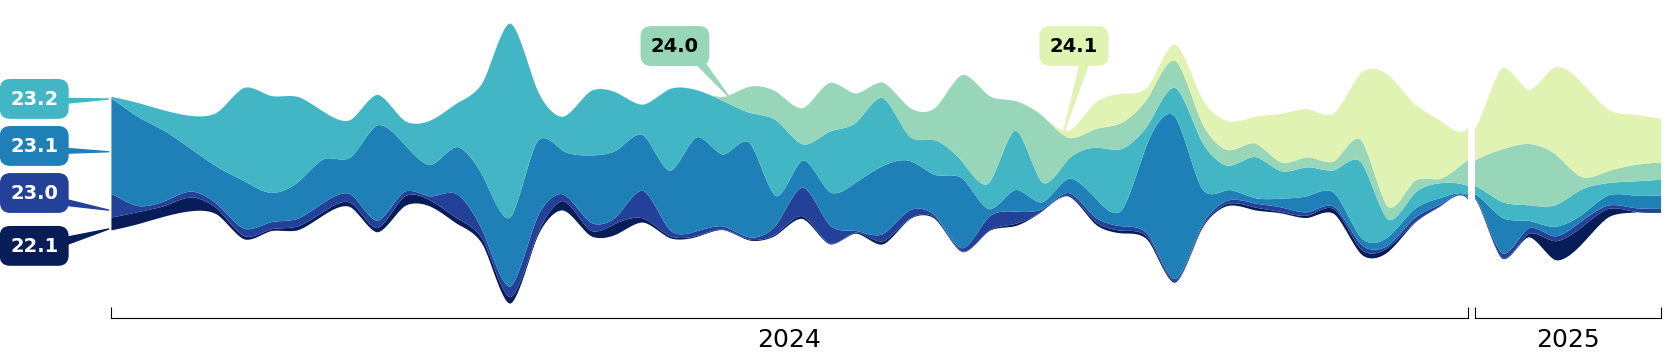

In [17]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(years),
    sharey="row",
    gridspec_kw={
        "width_ratios": weeks_per_year,
        "wspace": 0.01,
        "hspace": 0.0,
    },
    figsize=(20,4),
)

labels = versions_success.columns

colors = [plt.cm.YlGnBu_r(i / (len(labels))) for i, _ in enumerate(labels)]

xlims = []
year_start_index = 0
for ax_i, yr in enumerate(years):
    if ax_i > 0:
        axes[ax_i].set_yticklabels([])
        axes[ax_i].set_yticks([])

    xaxis = np.arange(len(data[year_index == yr]))
    axes[ax_i].stackplot(
        xnew,
        smoothed_data.T,
        baseline="sym",
        labels=labels,
        colors=colors,
    )
     
    axes[ax_i].spines['right'].set_visible(False)
    axes[ax_i].spines['top'].set_visible(False)
    axes[ax_i].spines['left'].set_visible(False)
    
    year_end_index = year_start_index + weeks_per_year[ax_i]
    xlims.append((year_start_index, year_end_index))
    
    axes[ax_i].set_xlim(xlims[-1])
    axes[ax_i].set_xticklabels([])
    axes[ax_i].set_xticks(xlims[-1])
    axes[ax_i].tick_params(direction="in", length=8)
    axes[ax_i].set_xlabel(f"{yr}", fontsize=18)
    year_start_index = year_end_index


# Annotate each year (ax) with release
axes[0].annotate(
    labels[0],  # 22.1
    xy=(0, -5500),
    xytext=(-2, -7000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="right",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[0],
        "ec": colors[0],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[0],
        "patchA": None,
        "patchB": None,
        "relpos": (0.8, 0.5),
    },
)

axes[0].annotate(
    labels[1],  # 23.0
    xy=(0, -4000),
    xytext=(-2, -2500),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="right",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[1],
        "ec": colors[1],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[1],
        "patchA": None,
        "patchB": None,
        "relpos": (0.5, 0.3),
    },
)

axes[0].annotate(
    labels[2],  # 23.1
    xy=(0, 1000),
    xytext=(-2, 1500),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="right",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[2],
        "ec": colors[2],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[2],
        "patchA": None,
        "patchB": None,
        "relpos": (0.2, 0.3),
    },
)

axes[0].annotate(
    labels[3],  # 23.2
    xy=(0, 5500),
    xytext=(-2, 5500),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="right",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[3],
        "ec": colors[3],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[3],
        "patchA": None,
        "patchB": None,
        "relpos": (0.2, 0.3),
    },
)

axes[1].annotate(
    labels[4],  # 24.0
    xy=(23, 5500),
    xytext=(20, 10000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="k",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[4],
        "ec": colors[4],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[4],
        "patchA": None,
        "patchB": None,
        "relpos": (0.8, 0.3),
    },
)


axes[1].annotate(
    labels[5],  # 24.1
    xy=(35.5, 2500),
    xytext=(35, 10000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="k",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[5],
        "ec": colors[5],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[5],
        "patchA": None,
        "patchB": None,
        "relpos": (0.8, 0.3),
    },
)

plt.savefig(
    f"{datetime.date.today().strftime('%Y%m%d')}_versionstream.png",
    dpi=300,
    bbox_inches='tight',
)